In [1]:
%matplotlib widget
from pathlib import Path

import numpy as np
import scipy.signal as sps

from spectrometer import FID1D, process, plot
from spectrometer.process import decaying_sinus

cm = 1 / 2.54

Did not find any configuration file. Using defaults.


In [2]:
# Load raw *.fid data
file = Path(
    "../data/20230828-161013-Toluene-1H-single_90_degree_pulse,length=9us,delay=25us,record_length=20000.0,sample_rate=320000.0,probe=andrew.fid"
)
fid = FID1D.from_file(file)

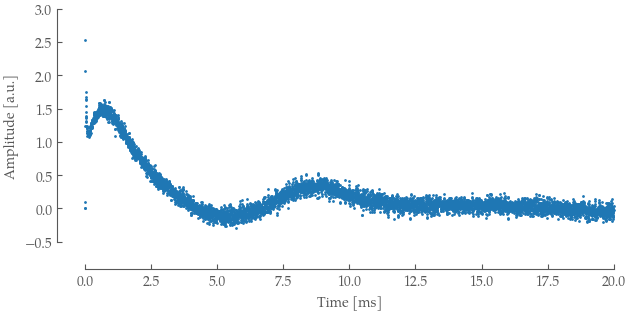

In [3]:
# Plot raw data
fig = fid.plot(
    figsize=(16.0 * cm, 8.0 * cm)  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
fig.savefig("fid_toluene.pdf")

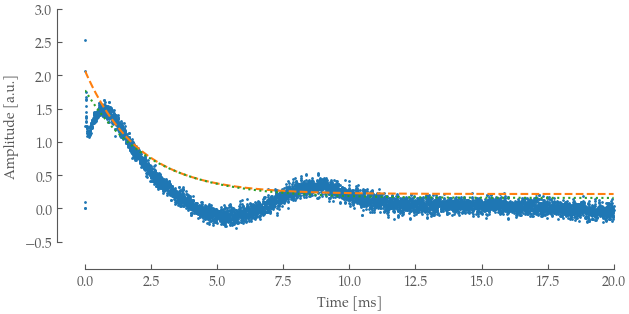

In [4]:
# Try fitting the envelope
try:
    # Plot raw data
    fig = fid.plot(
        figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
    )
    axes = fig.axes[0]

    envelope = np.abs(sps.hilbert(fid.real))
    fit_exp_decay = process.exp_decay.fit(fid.ms_scale, envelope)
    ms_scale_fine = np.linspace(
        fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10
    )
    axes.plot(
        ms_scale_fine,
        fit_exp_decay(ms_scale_fine),
        linestyle="--",
    )

    # Try fitting the absolute directly
    fit_abs = process.exp_decay.fit(fid.ms_scale, fid.absolute)
    axes.plot(
        ms_scale_fine,
        fit_abs(ms_scale_fine),
        linestyle=":",
    )
except RuntimeError:
    pass

fig.savefig("fid_toluene_envelope_fit.pdf")

Amplitude: 1.9566001822228576
Frequency: 0.1173497872671255
Phase: 0.5720570233822698
Offset: 0.09597343578158408
Lambda: 0.4121307663443311


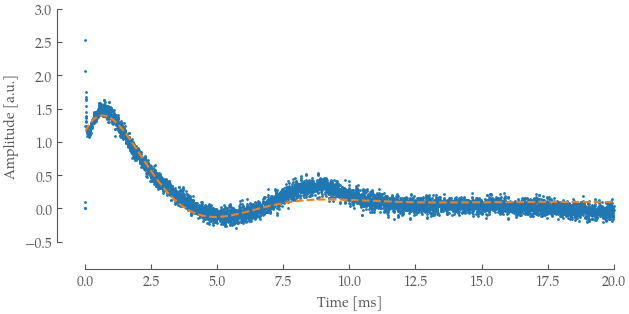

In [5]:
# Try to plot simple least squares fit for a decaying sinusoid
decaying_sinus_fit = decaying_sinus.fit(fid.ms_scale, fid.real)
ms_scale_fine = np.linspace(fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10)
print(decaying_sinus_fit)

# Plot raw
fig = fid.plot(figsize=(16 * cm, 8 * cm))  # Wide Layout: ~16cm, Margin Layout: 10.7cm

# Plot fit
fig.axes[0].plot(
    ms_scale_fine,
    decaying_sinus_fit(ms_scale_fine),
    linestyle="--",
)

fig.savefig("fid_toluene_sine_fit.pdf")

Phase Shift: -28.915625000000038


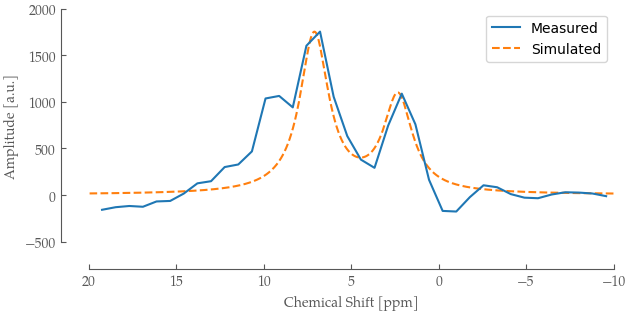

In [6]:
# Measured Spectrum
fid.carrier_freq = 170  # Manually adjust shift (there's no locking yet)
spectrum, p0 = fid.spectrum()
print(f"Phase Shift: {p0}")

peak_spectrum = spectrum.ppm.crop(-10, 19)  # minimize whitespace
peak_fig = peak_spectrum.ppm.plot(figsize=(16 * cm, 8 * cm), linestyle="-", markersize=0, label="Measured")

# Load simulated spectrum
# B_0 = 25MHz, Linewidth = 50Hz, Simulated with MestReNova 14.3.3
toluene = np.loadtxt(f"../data/toluene_simulation_25MHz_field_50Hz_linewidth.csv")
ppm_scale, fft = toluene[:-1, 0], toluene[:-1, 1]
scale = np.max(spectrum.real) / np.max(fft.real)  # Scale maximum to fit measured data
peak_fig.axes[0].plot(ppm_scale, fft.real*scale, linestyle="--", label="Simulated", zorder=-1)

# plot.format_axes(axes)
peak_fig.axes[0].invert_xaxis()
peak_fig.axes[0].legend()
peak_fig.savefig("fft_toluene.pdf")